# Практическое задание к уроку "Сегментация изображений (Pytorch)"

In [33]:
!pip install segmentation_models_pytorch

In [34]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import segmentation_models_pytorch as smp

In [35]:
DATA_ROOT = './data'
MASK_ROOT = './mask'
PROCESSED_MASK_ROOT = './mask_processed'
META_FILEPATH = './list.csv'

### Загрузим мета информацию из файла

In [36]:
meta = pd.read_csv(META_FILEPATH)

In [37]:
meta

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png
...,...,...,...,...,...,...,...,...,...
28589,image00028590.jpg,1280,720,Lips,657,347,817,450,mask00028590.png
28590,image00028591.jpg,1280,720,Lips,713,325,884,388,mask00028591.png
28591,image00028592.jpg,1280,720,Lips,659,401,808,488,mask00028592.png
28592,image00028593.jpg,1280,720,Lips,689,334,839,431,mask00028593.png


### Просмотрим одно из изображений датасета

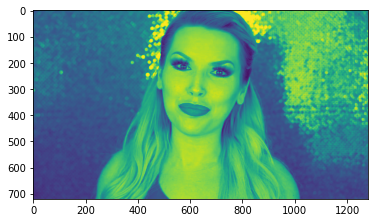

In [38]:
img = plt.imread(DATA_ROOT + '/image00000005.jpg')
plt.imshow(img[..., 0]);

### И маску к нему

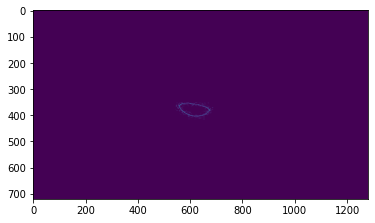

In [39]:
img = plt.imread(MASK_ROOT + '/mask00000005.png')
plt.imshow(img[..., 0]);

In [40]:
meta['class'].value_counts()

Lips    28594
Name: class, dtype: int64

В датасете один класс, все объекты принадлежат этому классу

### Оформим датасет pytorch

In [41]:
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch.nn import functional as F

In [166]:
labels = ['Unlabeled','Lips']

class LibsDataset(Dataset):
    def __init__(self, data, preprocessing=None):
        # Подаем наш подготовленный датафрейм
        self.data = data
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data.iloc[:,1]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data.index)
        self.class_values = [0, 1]
        self.preprocessing = preprocessing
        
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значений
        img = cv2.cvtColor(cv2.imread(os.path.join(DATA_ROOT, self.image_arr[index])), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        img = np.asarray(img).astype('float')
        
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
            # Нормализуем изображение в значениях [0, 1]
            img = torch.as_tensor(img) / 255.0
        img = img.permute(2, 0, 1)
        
        # считаем сегментированную картинку
        mask_image_path = os.path.join(MASK_ROOT, self.label_arr[index])
        mask = cv2.cvtColor(cv2.imread(mask_image_path), cv2.COLOR_BGR2RGB)
        cls_mask = cv2.resize(mask, (256, 256))
        cls_mask = cls_mask[..., 1]
        cls_mask = np.where(cls_mask > 128, 1, 0)[:,:]
        cls_mask = cls_mask.astype('float')
        masks = [cls_mask]
            
        masks = torch.as_tensor(masks, dtype=torch.float)
        
        return (img.float(), masks)

    def __len__(self):
        return self.data_len

In [167]:
df = meta.drop(columns=[    
    "width",
    "height",
    "class",
    "xmin",
    "ymin",
    "xmax",
    "ymax"
])
df

,filename,mask
0,image00000001.jpg,mask00000001.png
1,image00000002.jpg,mask00000002.png
2,image00000003.jpg,mask00000003.png
3,image00000004.jpg,mask00000004.png
4,image00000005.jpg,mask00000005.png
...,...,...
28589,image00028590.jpg,mask00028590.png
28590,image00028591.jpg,mask00028591.png
28591,image00028592.jpg,mask00028592.png
28592,image00028593.jpg,mask00028593.png


### === Этот блок выполняется один раз (не использовался в итоге) ===

In [168]:
# broken_mask_indexes = []
# for index, mask in enumerate(df['mask']):
#     try:
#         mask_image_path = mask_image_path = os.path.join(PROCESSED_MASK_ROOT, mask)
#         cv2.cvtColor(cv2.imread(mask_image_path), cv2.COLOR_BGR2RGB)
#     except Exception:
#         broken_mask_indexes.append(index)
# broken_mask_indexes

In [169]:
# from numpy import savetxt
# savetxt('broken_mask_indexes.csv', broken_mask_indexes, delimiter=',')

### ==================================

In [170]:
from numpy import loadtxt
broken_mask_indexes = loadtxt('broken_mask_indexes.csv', delimiter=',')

In [171]:
for index in broken_mask_indexes:
    df = df.drop(index=index)

### === Этот блок выполняется один раз (не использовался в итоге) ===

In [172]:
# mask_list = []
# for dirname, _, filenames in os.walk(MASK_ROOT):
#     for filename in filenames:
#         mask_list.append(filename)
# mask_list

In [173]:
# # Преобразование маски в монохромное изображение
# def mask_b(filename, save_path):
#     mask = cv2.imread(os.path.join(MASK_ROOT, filename), cv2.IMREAD_GRAYSCALE)
#     (thresh, mask_binary) = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)
    
#     cv2.imwrite(os.path.join(save_path, filename), mask_binary)
#     return os.path.join(save_path, filename)

In [174]:
# for path in df['mask']:
#     mask_b(path, './mask_processed')

### ==================================

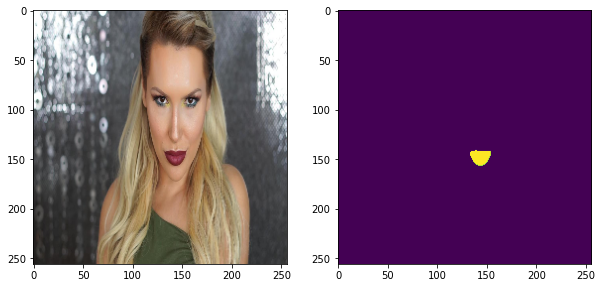

In [175]:
dataset = LibsDataset(df)
img, masks = dataset[0]
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(masks.permute(1, 2, 0))
plt.show()

### Создадим модель

In [176]:
model = smp.Unet(
    activation='sigmoid', 
    classes=1, 
    encoder_name='resnet34'
)

preprocess_input = smp.encoders.get_preprocessing_fn(
    encoder_name='resnet34', 
    pretrained='imagenet'
)

### Разобьем данные на train и test выборки

In [177]:
from sklearn.model_selection import train_test_split

# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df, test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = LibsDataset(X_train, preprocessing=preprocess_input)
test_data = LibsDataset(X_test, preprocessing=preprocess_input)

In [178]:
train_data_loader = DataLoader(
    train_data,
    batch_size=4,
    shuffle=True
)

test_data_loader = DataLoader(
    test_data, 
    batch_size=4,
    shuffle=False
)

In [179]:
import torch
import torch.nn as nn

def conv_block(in_channels,  out_channels):
    conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=out_channels),
        nn.Conv2d(out_channels, out_channels, kernel_size=3),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=out_channels)
    )
    return conv

### Обучим модель

In [180]:
learning_rate = 0.001
epochs = 1

In [181]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [182]:
sample = (next(iter(train_data_loader)))
sample[1].shape

torch.Size([4, 1, 256, 256])

In [183]:
out = model(sample[0].to(device))
out.shape

torch.Size([4, 1, 256, 256])

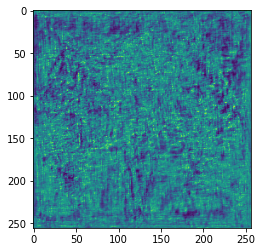

In [184]:
plt.imshow(out[0][0].detach().cpu());

In [185]:
optimizer = torch.optim.Adam(model.parameters())

In [186]:
total_steps = len(train_data_loader)
print(f"{epochs} epochs, {total_steps} total_steps per epoch")

1 epochs, 4995 total_steps per epoch


In [187]:
criterion = smp.utils.losses.BCELoss()
metrics = [smp.utils.metrics.IoU(), ]
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [199]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=criterion, 
    metrics=metrics,
    optimizer=optimizer,
    device=device,
    verbose=True
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=criterion, 
    metrics=metrics,
    device=device,
    verbose=True
)

In [200]:
print(f'Epoch: 1')
train_logs = train_epoch.run(train_data_loader)

Epoch: 1
train: 100%|██████████| 4995/4995 [4:11:59<00:00,  3.03s/it, bce_loss - 0.001566, iou_score - 0.8788]


In [197]:
test_logs = valid_epoch.run(test_data_loader)

done


In [195]:
torch.save(model, './model.pth')
print('done')

valid: 100%|██████████| 2141/2141 [34:30<00:00,  1.03it/s, bce_loss - 0.001244, iou_score - 0.8953]


### Проверим модель, выполнив несколько предсказаний

In [203]:
iterator = iter(train_data_loader)

In [204]:
images, labels = iterator.next()

outputs = model(images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


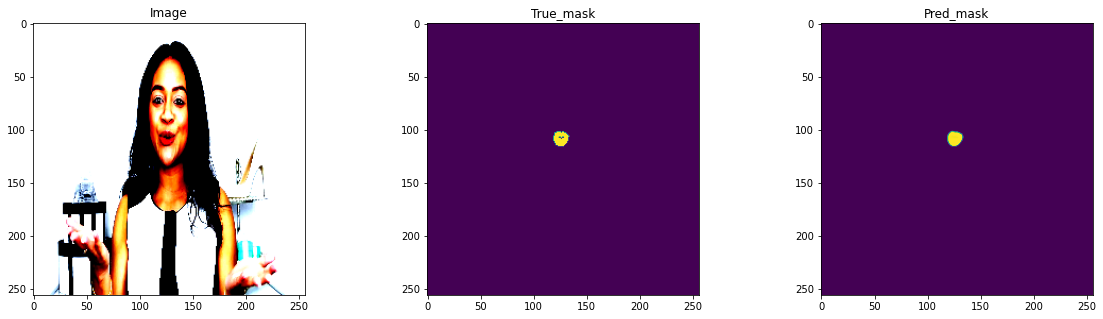

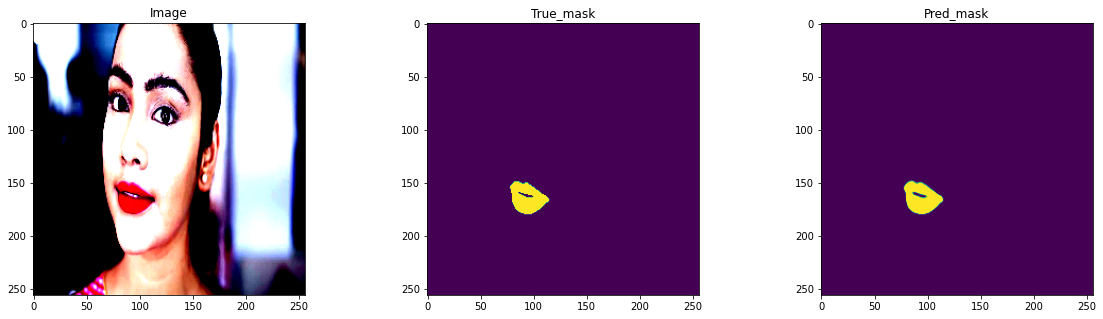

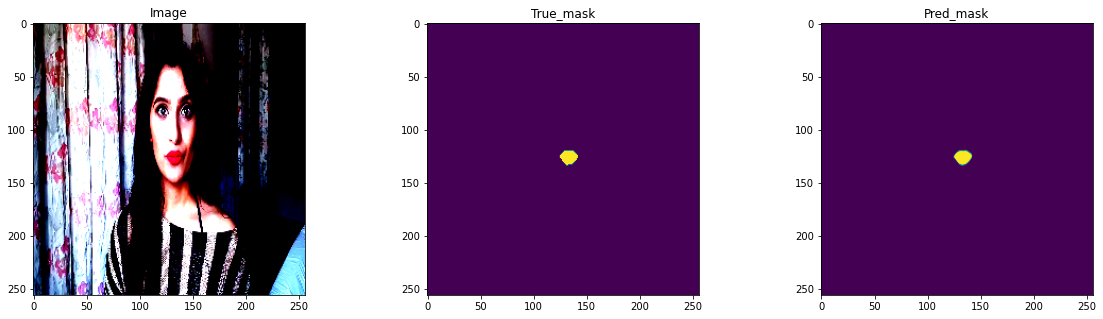

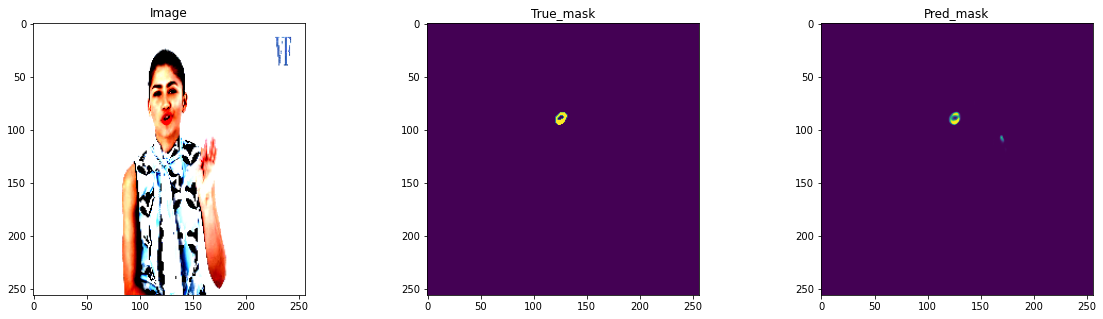

In [206]:
for i in range(images.shape[0]):
    
    fig, (ax1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(20, 5))
    
    image = images[i].permute(1, 2, 0)
    
    ax1.imshow(image.cpu())
    ax1.set_title('Image')
    
    ax_2.imshow(labels[i, ].cpu().permute(1, 2, 0))
    ax_2.set_title('True_mask')
    
    ax_3.imshow(outputs.detach().cpu()[i, ].permute(1, 2, 0))
    ax_3.set_title('Pred_mask')